# Instancia de librarias

In [1]:
import pandas as pd
import numpy as np
# import datetime as dt
from datetime import datetime

import scipy.stats as stats
import statistics

# Series de tiempo

from statsmodels.tsa.seasonal import seasonal_decompose # graficas de estacionalidad y tendencia
from statsmodels.tsa.stattools import adfuller # prueba 
from statsmodels.tsa.statespace.sarimax import SARIMAX #SARIMAX
import pmdarima as pm # autoarima

# import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

# Formato de visualización por centenas
pd.options.display.float_format = '{:,.2f}'.format

# Graficas
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;sns.set_theme(color_codes=True)

plt.rcParams["figure.figsize"] = (12,6)

# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

print("Setup complete")

Setup complete


# Importación de datos

In [2]:
path = r'E:\\skillsForIndustry/project_wallmart/data/Walmart_Store_sales.csv'
wall_data = pd.read_csv(path, header=0, encoding='utf-8')

In [3]:
wall_data['Date'] = pd.to_datetime(wall_data['Date'],format="%d-%m-%Y",dayfirst=True)
# wall_data.info()
wall_data['year'] = pd.DatetimeIndex(wall_data['Date']).year
wall_data['month'] = pd.DatetimeIndex(wall_data['Date']).month
wall_data['day'] = pd.DatetimeIndex(wall_data['Date']).day
wall_data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day
0,1,2010-02-05,"1,643,690.90",0,42.31,2.57,211.10,8.11,2010,2,5
1,1,2010-02-12,"1,641,957.44",1,38.51,2.55,211.24,8.11,2010,2,12
2,1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11,2010,2,19
3,1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11,2010,2,26
4,1,2010-03-05,"1,554,806.68",0,46.50,2.62,211.35,8.11,2010,3,5


## Build prediction models to forecast demand (Modeling)

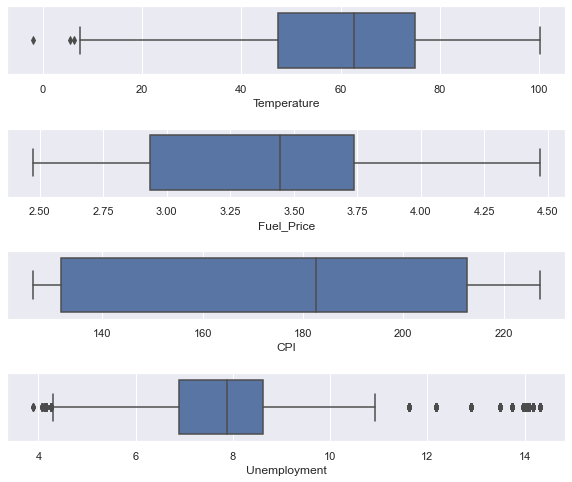

In [4]:
# fig, axs = plt.subplots(4)
# sns.boxplot(wall_data.Temperature, ax=axs[0])
# sns.boxplot(wall_data.Fuel_Price,ax=axs[1])
# sns.boxplot(wall_data.CPI,ax=axs[2])
# sns.boxplot(wall_data.Unemployment,ax=axs[3])

# fig, axs = plt.subplots(4,figsize=(10,8),constrained_layout = True)
X = wall_data[['Temperature','Fuel_Price','CPI','Unemployment']]
# X = wall_data.loc[:,['Temperature','Fuel_Price','CPI','Unemployment']]

fig, axs = plt.subplots(4,figsize=(10,8))
for i,j in enumerate(X):
    sns.boxplot(wall_data[j], ax=axs[i])
    fig.subplots_adjust(hspace=0.8)

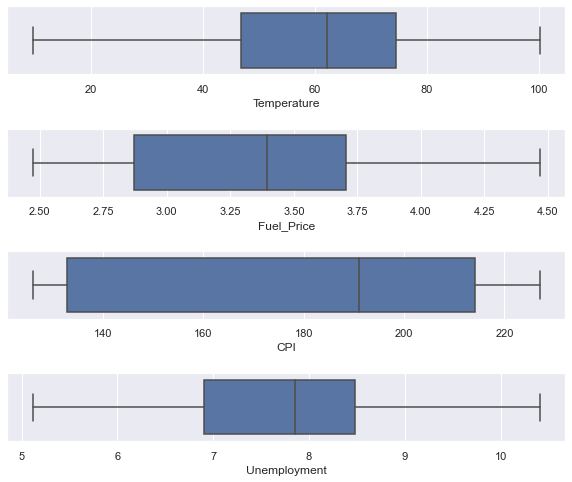

In [5]:
wall_data_2 = wall_data[(wall_data['Temperature']>8)&(wall_data['Unemployment']>=5)&(wall_data['Unemployment']<=10.5)]
X = wall_data_2[['Temperature','Fuel_Price','CPI','Unemployment']]
fig, axs = plt.subplots(4,figsize=(10,8))
for i,j in enumerate(X):
    sns.boxplot(wall_data_2[j], ax=axs[i])
    fig.subplots_adjust(hspace=0.8)

#### Importar librarias de regresión líneal, metricas y randomforest

In [6]:
# ------------------------------------------------ TODO ------------------------------------------------------ #
from sklearn.model_selection import train_test_split 
# Para series de tiempo no es bueno usar train_test_split. Ya que el trian y el test tienen datos
# de manera aleatoria. La segmentación se debe hacer por medio de peridodos de tiempo,
# es decir el train:antiguos,test:recientes
# Sólo se toma en cuenta Para los modelos regresion líneal, random forest y arbol de decisiones
# ------------------------------------------------ TODO ------------------------------------------------------ #
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler  # Estandarización de los datos
from sklearn.model_selection import cross_val_score

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

#### Performance

In [7]:
def performance(a,b):
    print('Mean Absolute Error: ',metrics.mean_absolute_error(a,b))
    print('Mean Square Error: ',metrics.mean_squared_error(a,b))
    print('Root Mean Square Error: ',np.sqrt(metrics.mean_squared_error(a,b)))
    print('Mean Absolute Percentage Error: ', metrics.mean_absolute_percentage_error(a,b))
    
    plt.figure(figsize=(10,8),dpi=60)
    sns.regplot(b,a);
    
def cross_validation(model,a,b):
    cv = cross_val_score(model,a,b,cv=10,scoring='r2')
    print(f'Cross validation: {cv.mean()*100}%')

#### ADF

In [8]:
def adf(series,column_name):
    print(f'Resultados ADF: ,{column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used', 'Observation number'])
    for key, value in dftest[4].items():
        dfoutput['Critical Values (%s)'%key] = value
    print(dfoutput)
    if ((dftest[1] > 0.00) & (dftest[1] <= 0.05)):
        print('Los datos son estacionarios')
    else:
        print('Los datos no son estacionarios')

In [9]:
# Con base al número de tienda, el precio de la gasolina, el indice
# de precios al consumidor y la tasa de desempleo
X = wall_data.loc[:,['Store','Fuel_Price','CPI','Unemployment','year','month','day']] 

# Predecir las ventas por semana 
y = wall_data['Weekly_Sales']   

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2) # corregir y segmentar

# Estandarización de los datos para eliminar outliers
sc = StandardScaler() #  (observacion - media) / sd
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [10]:
print(wall_data.shape[0],wall_data_2.shape[0],X_train.shape[0],X_test.shape[0], y_train.shape[0],y_test.shape[0])

# Variables independientes - Objetivo
# X_train # 80%
# X_test # 20%

# Variables que queremos predecir. Ventas semanales
# y_train
# y_test

6435 5733 5148 1287 5148 1287


## Linear regression

Accuracy train:  14.57961096091439
Accuracy test:  14.52934011830277
Mean Absolute Error:  423425.9079047064
Mean Square Error:  272533372724.41547
Root Mean Square Error:  522047.28973955556
Mean Absolute Percentage Error:  0.634164963303241
Cross validation: 14.179561928241272%


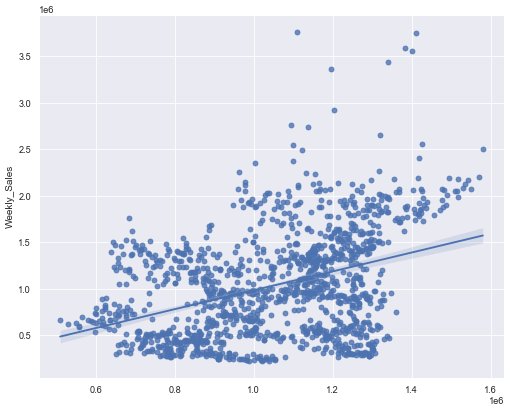

In [11]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_test)

# Medir la exactitud del modelo
print('Accuracy train: ', lin_reg.score(X_train,y_train)*100)
print('Accuracy test: ', metrics.r2_score(y_test,y_pred)*100)
performance(y_test,y_pred)
cross_validation(lin_reg,X_train,y_train)

## Random Forest

Accuracy train:  99.44646047272063
Accuracy test:  91.69561384025782
Mean Absolute Error:  83926.16967969298
Mean Square Error:  26479523752.982536
Root Mean Square Error:  162725.30151449263
Mean Absolute Percentage Error:  0.11735854859328788
Cross validation: 96.18281574960521%


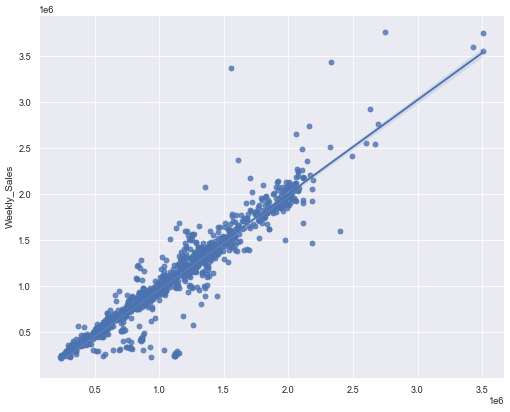

In [12]:
rdf = RandomForestRegressor(n_estimators=400,max_depth=15,n_jobs=5)
rdf.fit(X_train,y_train)
y_pred = rdf.predict(X_test)    

# Medir la exactitud del modelo
print('Accuracy train: ', rdf.score(X_train,y_train)*100)
print('Accuracy test: ', metrics.r2_score(y_test,y_pred)*100)
performance(y_test,y_pred)
cross_validation(rdf,X_train,y_train)

## Decision Tree Regressor

Accuracy train:  99.81571402941388
Accuracy test:  86.41002392498179
Mean Absolute Error:  96891.35534438075
Mean Square Error:  43333256348.96553
Root Mean Square Error:  208166.41503606082
Mean Absolute Percentage Error:  0.13380849548896356
Cross validation: 94.5077692109795%


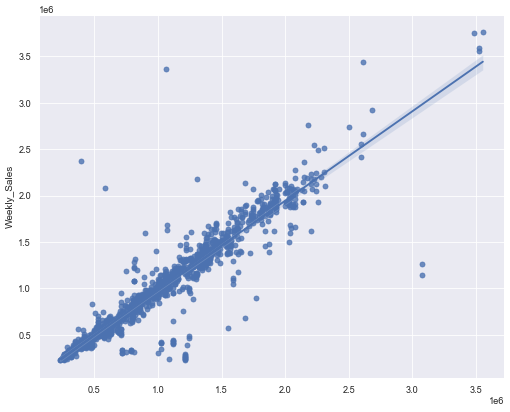

In [13]:
dtr = DecisionTreeRegressor(max_depth=15)
dtr.fit(X_train,y_train)
y_pred = dtr.predict(X_test)    

# Medir la exactitud del modelo
print('Accuracy train: ', dtr.score(X_train,y_train)*100)
print('Accuracy test: ', metrics.r2_score(y_test,y_pred)*100)
performance(y_test,y_pred)
cross_validation(dtr,X_train,y_train)